In [105]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [106]:
# Load test set
test_df = pd.read_excel("test_x.xlsx", index_col=False)

# Save IDs
ids = test_df["ID"]

# Get X
X = test_df.drop(columns=["ID"])

In [107]:
from sklearn.impute import SimpleImputer
# Replace missing values with median
imputer = SimpleImputer(missing_values=999, strategy="median")
imputer.set_output(transform="pandas")
X = imputer.fit_transform(X)

In [108]:
import pickle

columns = X.columns

with open("medians.pkl", "rb") as f:
    medians = pickle.load(f)

def replace_outliers(df):
    columns = df.columns
    for column in columns:
        Q1 = df[column].quantile(0.25) 
        Q3 = df[column].quantile(0.75)  
        IQR = Q3 - Q1                  
        lower_bound = Q1 - 1.5 * IQR   
        upper_bound = Q3 + 1.5 * IQR   
        median = medians[column]
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
        
replace_outliers(X)

In [109]:
# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform="pandas")
Xs = scaler.fit_transform(X)

In [110]:
from sklearn.decomposition import PCA

'''
with open("pca_classification.pkl", "rb") as f:
    pca = pickle.load(f)

Xs_important = Xs[["ER","HER2","Gene"]]
Xs = Xs.drop(columns=["ER","HER2","Gene"])

Xs = pca.transform(Xs)

Xs = Xs_important.join(Xs)
'''

# Load model

with open("model_classification.pkl", "rb") as f:
    model = pickle.load(f)

predicted_y = model.predict(Xs)

In [111]:
actual_y = pd.read_excel("test_y.xlsx", index_col=False)
actual_y = actual_y["pCR (outcome)"]

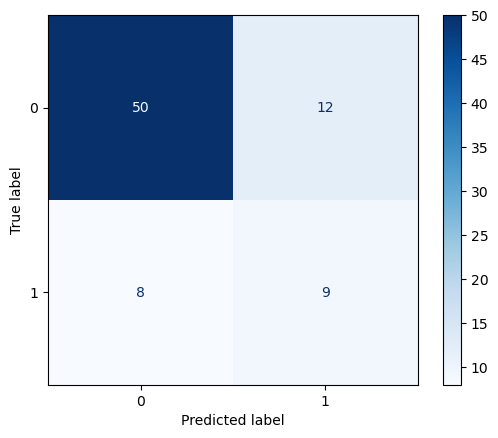

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actual_y,predicted_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)

In [115]:
from sklearn.metrics import balanced_accuracy_score

print(balanced_accuracy_score(actual_y, predicted_y))

0.6679316888045541


In [113]:
predicted_y = pd.DataFrame(predicted_y)

output_df = ids.to_frame().join(predicted_y)
output_df.to_csv("PCRPrediction.csv",index=False,header=False)